Initial Imports

In [ ]:
import csv
import time
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
from datetime import datetime, timedelta
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Generate map of cities and their respective coordinates

In [ ]:
# Replace 'file.csv' with your CSV file's name and path
file_path = 'data/tr.csv'

# Create an empty dictionary to store city coordinates
city_coordinates = {}

# Open the CSV file and read data
with open(file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        city = row['city']
        lat = float(row['lat'])
        lng = float(row['lng'])
        city_coordinates[city] = (lat, lng)

# Display the dictionary containing city coordinates
for city, coordinates in city_coordinates.items():
    print(f"City: {city}, Coordinates: {coordinates}")
city_coordinates

In [ ]:
today = datetime.now() - timedelta(days=1) # Get today's date
one_year_ago = today - timedelta(days=365)  # Subtract 365 days for one year
today

In [ ]:
def format_date(date):
	formatted_date = date.strftime('%Y-%m-%d')
	return formatted_date

In [ ]:
def api_call(lat,long):
	# Setup the Open-Meteo API client with cache and retry on error
	cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	openmeteo = openmeteo_requests.Client(session = retry_session)
	
	# Make sure all required weather variables are listed here
	# The order of variables in hourly or daily is important to assign them correctly below
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": long,
		"start_date": format_date(one_year_ago),
		"end_date": format_date(today),
		"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "surface_pressure", "cloud_cover", "wind_speed_10m"]
	}
	responses = openmeteo.weather_api(url, params=params)
	
	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
	print(f"Elevation {response.Elevation()} m asl")
	
	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
	hourly_rain = hourly.Variables(2).ValuesAsNumpy()
	hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
	hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
	
	hourly_data = {"date": pd.date_range(
		start=pd.to_datetime(hourly.Time(), unit="s"),
		end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
		freq=pd.Timedelta(seconds=hourly.Interval()),
		inclusive="left"
	), "temperature_2m": hourly_temperature_2m, "relative_humidity_2m": hourly_relative_humidity_2m, "rain": hourly_rain,
			"snowfall": hourly_snowfall, "surface_pressure": hourly_surface_pressure, "cloud_cover": hourly_cloud_cover,
		"wind_speed_10m": hourly_wind_speed_10m}
	
	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe

In [ ]:
data_frame = pd.DataFrame
for city, (lat, lng) in city_coordinates.items():
    df = api_call(lat, lng)
    df['city_name'] = city
    df['latitude'] = lat
    df['longitude'] = lng
    if data_frame.empty:
        data_frame = df
    else:
        data_frame = pd.concat((data_frame, df))
data_frame

In [ ]:
data_frame.head()

# Feature selection

In [ ]:
print(data_frame.columns)

In [ ]:
data_frame['date'] = pd.to_datetime(data_frame['date']).astype('int64') / 10**9  # Convert nanoseconds to seconds
selected_features = data_frame[['date', 'latitude', 'longitude']]

target_variables = ['rain','snowfall', 'cloud_cover', 'wind_speed_10m','surface_pressure']

# Assuming you want to predict each target variable for the next hour
for target_variable in target_variables:
    # Shift the target variable by 1 hour to align with features
    data_frame[target_variable] = data_frame[target_variable].shift(-1)

# Drop the last row to maintain alignment of features and labels
data_frame = data_frame.dropna()
data_frame

In [ ]:
# Splitting features and labels
X = data_frame[selected_features.columns]  # Features
X

In [ ]:
y = data_frame[target_variables]  # Labels
y

# Creating Test and Training Data

In [ ]:
# Select numerical columns only for conversion to tensors
numerical_columns_X = X.select_dtypes(include=['float32', 'float64']).columns
X_numeric = X[numerical_columns_X]
X_numeric

In [ ]:
# Initialize StandardScaler
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)
X_numeric = pd.DataFrame(X_numeric, columns=numerical_columns_X)
X_numeric

In [ ]:
numerical_columns_y = y.select_dtypes(include=['float32', 'float64']).columns
y_numeric = y[numerical_columns_y]
y_numeric

In [ ]:
# Convert numerical columns to PyTorch tensors
X_tensor = torch.tensor(X_numeric.values, dtype=torch.float32)
X_tensor

In [ ]:
y_tensor = torch.tensor(y_numeric.values, dtype=torch.float32)
y_tensor

In [ ]:
# Check for missing values in X_tensor and y_tensor
missing_X = np.isnan(X_tensor).any()
missing_y = np.isnan(y_tensor).any()
print(f"Missing values in X_tensor: {missing_X}")
print(f"Missing values in y_tensor: {missing_y}")

# Verify the lengths of X_tensor and y_tensor
print(f"Length of X_tensor: {len(X_tensor)}")
print(f"Length of y_tensor: {len(y_tensor)}")

In [ ]:
# Split data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test

In [ ]:
# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
train_dataset

In [ ]:
test_dataset = TensorDataset(X_test, y_test)
test_dataset

In [ ]:
# Define batch size for DataLoader
batch_size = 64
batch_size

In [ ]:
# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader

In [ ]:
class ImproveModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(ImproveModel, self).__init__()
        layers = []
        prev_size = input_size
        self.hidden_sizes = hidden_sizes
        
        for idx, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch Normalization
            layers.append(nn.ReLU())  # ReLU activation
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.network = nn.Sequential(*layers)
        
        # Weight initialization (optional)
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.BatchNorm1d)):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Implementing skip connections (residual connections)
        out = x
        for idx, layer in enumerate(self.network):
            out = layer(out)
            if idx % 4 == 3:  # After every 4 layers (Linear -> BatchNorm -> ReLU -> Dropout)
                if out.shape[1] == x.shape[1]:  # Check if the shapes match for addition
                    out += x  # Add the input (skip connection)
                x = out  # Update x for the next skip connection
        
        return out


In [ ]:
# Define input, hidden, and output sizes based on your data
input_size = X_train.shape[1]  # Number of features
hidden_sizes = [64, 32]
output_size = y_train.shape[1]  # Number of output variables

In [ ]:
# Initialize the more complex model
model = ImprovedModel(input_size, hidden_sizes, output_size)
model

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adam optimizer

In [ ]:
# Train the model
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

In [ ]:
# Evaluate the model
model.eval()
test_loss = 0.0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

        all_predictions.extend(outputs.numpy())  # Collect predictions
        all_labels.extend(labels.numpy())  # Collect actual labels

# Calculate evaluation metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(all_labels, all_predictions)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r_squared:.4f}")


In [ ]:
# Extract weights from the model's layers
def extract_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().numpy())
    return weights

# Get the weights from the model
model_weights = extract_weights(model)

# Visualize the weights of each layer
for i, layer_weights in enumerate(model_weights, 1):
    plt.figure(figsize=(8, 6))
    plt.hist(layer_weights.flatten(), bins=50)
    plt.title(f"Layer {i} Weights Distribution")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [ ]:
def display_menu(city_coordinates):
    print("Select a city:")
    for index, (city, coordinates) in enumerate(city_coordinates.items(), start=1):
        print(f"{index}. {city}")

In [ ]:
def get_city_choice(city_coordinates):
    while True:
        display_menu(city_coordinates)
        choice = input("Enter the number corresponding to the city: ")
        try:
            choice = int(choice)
            if 1 <= choice <= len(city_coordinates):
                city = list(city_coordinates.keys())[choice - 1]
                coordinates = city_coordinates[city]
                return city, coordinates
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

In [ ]:
# Get user's choice of city and coordinates
selected_city, selected_coordinates = get_city_choice(city_coordinates)
print(f"You selected: {selected_city} with coordinates: {selected_coordinates}")

In [ ]:
# Get the timestamp for today minus 1 hour
input_date = (datetime.now() - timedelta(hours=1))
prediction_data = [input_date.strftime('%Y-%m-%d %H:%M:%S'), selected_city]
prediction_data

In [ ]:
# Convert the date-time string to a timestamp
date_string = prediction_data[0]
date_time = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
timestamp = date_time.timestamp()
timestamp

In [ ]:
# Get the coordinates of the selected city
selected_city = prediction_data[1]
selected_coordinates = city_coordinates.get(selected_city)
selected_coordinates

In [ ]:
 # Combine timestamp and coordinates into a single tensor
tensor_data = [timestamp] + list(selected_coordinates)
tensor_array = torch.tensor(tensor_data)
tensor_array = tensor_array.unsqueeze(0)
tensor_array

In [ ]:
model.eval()
# Perform predictions
with torch.no_grad():
    predictions = model(tensor_array)
    print(predictions)

In [ ]:
predictions_numpy_array = predictions.numpy()
predictions_numpy_array

In [ ]:
# Column names as per your format
column_names = ['rain', 'snowfall', 'cloud_cover', 'wind_speed_10m', 'surface_pressure']

# Convert NumPy array to DataFrame
predictions_frame = pd.DataFrame([predictions_numpy_array], columns=column_names)
predictions_frame

# IMAGE GENERATION

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision.utils import save_image
import os
from PIL import Image
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

### DATA

 Cloudy    285 imgs    \
 Rain      215 imgs    \
 Shine     253 imgs    

 


### GAN MODEL

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, img_shape),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 50, 50)
        return img

# Définir le discriminateur
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [31]:
# Configurer les paramètres
latent_dim = 100
img_shape = 50 * 50 * 1
lr = 0.0001
batch_size = 64
epochs = 100
sample_interval = 100

### Data

In [32]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = os.listdir(folder_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [33]:
cloudy_dataset = CustomDataset('./images/cloudy', transform=transform)
cloudy_dataloader = DataLoader(cloudy_dataset, batch_size=batch_size, shuffle=True)

rain_dataset = CustomDataset('./images/rain', transform=transform)
rain_dataloader = DataLoader(rain_dataset, batch_size=batch_size, shuffle=True)

shine_dataset = CustomDataset('./images/shine', transform=transform)
shine_dataloader = DataLoader(shine_dataset, batch_size=batch_size, shuffle=True)

dataset_dict = {
    "cloudy" : cloudy_dataloader,
    "rain" : rain_dataloader,
    "shine" : shine_dataloader
}

### Training Loop

In [34]:
def train_loop(dataloader,class_name,generator,discriminator,loss,optimizer_G,optimizer_D):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            # Adversarial ground truths
            valid = torch.ones(imgs.size(0), 1)
            fake = torch.zeros(imgs.size(0), 1)
    
            # Configure input
            real_imgs = imgs.type(torch.FloatTensor)
    
            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim)
            gen_imgs = generator(z)
            g_loss = loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()
    
            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = loss(discriminator(real_imgs), valid)
            fake_loss = loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
    
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    
            #if batches_done % sample_interval == 0:
            #   save_image(gen_imgs.data[:25], f"./gan_images/{batches_done}.png", nrow=5, normalize=True)

    torch.save(generator.state_dict(), './models/generator_'+class_name+'.pth')

Train models

In [51]:
weather_list = ["cloudy",
                "rain",
                "shine"
                ]

for weather in weather_list:

    generator = Generator(latent_dim, img_shape)
    discriminator = Discriminator(img_shape)
    generator.apply(weights_init)
    discriminator.apply(weights_init)

    loss = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    #It saves generators in ./models/
    train_loop(
        dataloader=dataset_dict[weather],
        class_name=weather,generator=generator,
        discriminator=discriminator,
        loss=loss,
        optimizer_G=optimizer_G,
        optimizer_D=optimizer_D
    )

[Epoch 0/100] [Batch 0/5] [D loss: 0.6995725631713867] [G loss: 0.6697902679443359]
[Epoch 0/100] [Batch 1/5] [D loss: 0.6724490523338318] [G loss: 0.6693601012229919]
[Epoch 0/100] [Batch 2/5] [D loss: 0.6521072387695312] [G loss: 0.6690511107444763]
[Epoch 0/100] [Batch 3/5] [D loss: 0.6269621849060059] [G loss: 0.6686810255050659]
[Epoch 0/100] [Batch 4/5] [D loss: 0.6035866141319275] [G loss: 0.6681519746780396]
[Epoch 1/100] [Batch 0/5] [D loss: 0.5766564011573792] [G loss: 0.667508602142334]
[Epoch 1/100] [Batch 1/5] [D loss: 0.5625776648521423] [G loss: 0.6664726734161377]
[Epoch 1/100] [Batch 2/5] [D loss: 0.5369486808776855] [G loss: 0.6646196842193604]
[Epoch 1/100] [Batch 3/5] [D loss: 0.5134982466697693] [G loss: 0.6624818444252014]
[Epoch 1/100] [Batch 4/5] [D loss: 0.4901675879955292] [G loss: 0.6599059104919434]
[Epoch 2/100] [Batch 0/5] [D loss: 0.4710938334465027] [G loss: 0.6565603017807007]
[Epoch 2/100] [Batch 1/5] [D loss: 0.46615952253341675] [G loss: 0.6517498493

### Generate an image

In [52]:
def generate_weather_image(rain,snowfall,cloud_cover,wind_speed,pressure):

    weather = "shine"

    if cloud_cover > 40 :
        weather = "cloudy"
    if rain > 0 :
        weather = "rain"
    if snowfall > 0 :
        weather = "cloudy"

    print(weather)
    generator = Generator(latent_dim, img_shape)
    generator.load_state_dict(torch.load('./models/generator_'+weather+'.pth'))
    generator.eval()
    
  
    with torch.no_grad():
        z = torch.randn(1, latent_dim)
        generated_image = generator(z)

    to_pil = ToPILImage()
    generated_image_pil = to_pil(generated_image[0].cpu())
    
 
    plt.imshow(generated_image_pil)
    plt.axis('off')
    plt.show()

    return weather, generated_image_pil

cloudy


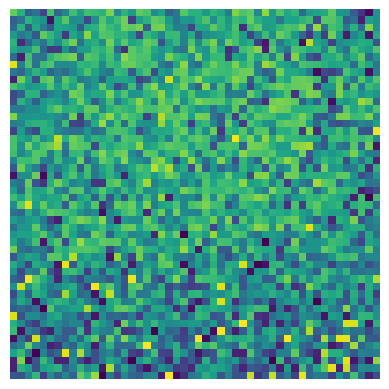

rain


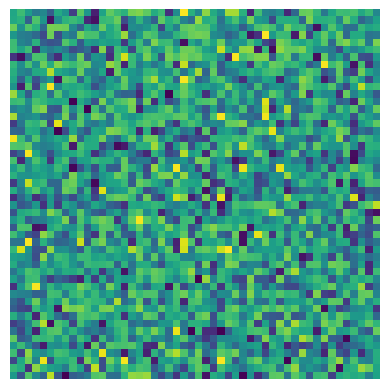

shine


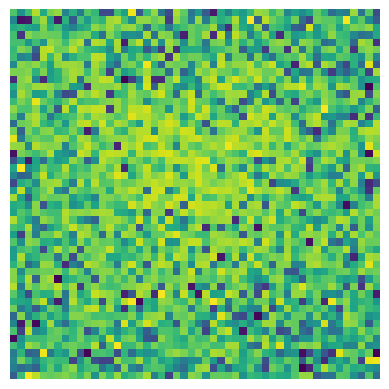

('shine', <PIL.Image.Image image mode=L size=50x50>)

In [64]:
#cloud
generate_weather_image(0,0,50,0,0)
#rain
generate_weather_image(40,0,50,0,0)
#shine
generate_weather_image(0,0,0,0,0)